This script loops through all datasets and evaluate their quality.

In [62]:
from dSPEECH.config import *
import numpy as np
import matplotlib.pyplot as plt
import librosa
import glob
from scipy.io import wavfile
from dSPEECH.evaluation_matrix.utils.util import colored_line
import soundfile

In [63]:
folders=['dataset1/reconstructed/mel_23/sid6/','dataset2/audio_samples/','dataset3/','dataset4/','dataset5/','dataset6/','dataset7/','dataset8/','dataset9/','dataset10/']

In [64]:
target_files=[]
for i in range(len(folders)):
    all_files_tmp=data_dir+'evaluation_matrix/'+folders[i]+'target_trial_*.wav'
    all_files=glob.glob(all_files_tmp)
    tmp=[]
    
    for j in range(len(all_files)):
        file=os.path.normpath(all_files[j])
        tmp.append(file)
    target_files.append(tmp)


In [65]:
pred_files=[]
for i in range(len(folders)):
    all_files_tmp=data_dir+'evaluation_matrix/'+folders[i]+'pred_trial_*.wav'
    all_files=glob.glob(all_files_tmp)
    tmp=[]
    
    for j in range(len(all_files)):
        file=os.path.normpath(all_files[j])
        tmp.append(file)
    pred_files.append(tmp)

In [5]:
all([len(file_num1)==len(file_num2) for file_num1, file_num2 in zip(target_files,pred_files)]) # one-to-one corresponding

True

In [16]:
# Combine target and pred audio, and save the combined files for GUI
# Only need to do below once:

if 1==0:
    index=0
    for i in range(len(pred_files)): # i-th dataest
        for j in range(len(pred_files[i])): # j-th trial of i-th dataset
            audio_t,sf=librosa.load(target_files[i][j])
            audio_p,sf=librosa.load(pred_files[i][j])
            comb=np.concatenate((audio_t,audio_p))
            
            filename=data_dir+'evaluation_matrix/GUI/'+str(index)+'_comb_'+str(j)+'_dataset_'+str(i)+'.wav'
            soundfile.write(filename, comb, sf)
            index=index+1


In [156]:
'''
Below is used by test_MCD.py

index=0
for i in range(len(pred_files)): # i-th dataest
        for j in range(len(pred_files[i])): # j-th trial of i-th dataset
            file_t=target_files[i][j]
            file_p=pred_files[i][j]
            
            to_this='copy '+file_t+' D:\\tmp\\mcd\\target\\'+str(index)+'.wav'
            os.system(to_this)
            
            to_this='copy '+file_p+' D:\\tmp\\mcd\\pred\\'+str(index)+'.wav'
            os.system(to_this)
            
            index=index+1
            
'''          

Test the melspectrogram calculation method.

In [52]:
wave_file=target_files[0][0]
audio,sf=librosa.load(wave_file)

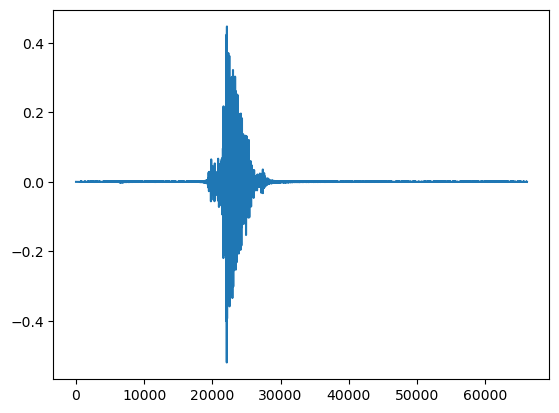

In [53]:
%matplotlib inline
plt.plot(audio)

In [56]:
S = librosa.feature.melspectrogram(y=audio, sr=sf, n_mels=128,fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)

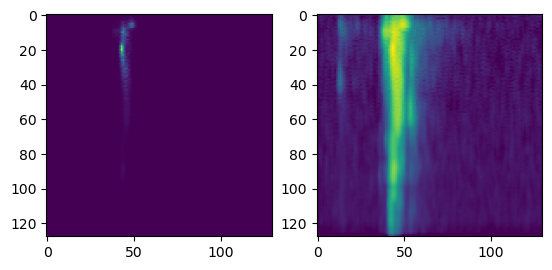

In [57]:
fig,ax=plt.subplots(1,2)
ax[0].imshow(S)
ax[1].imshow(S_dB)

Use librosa to loop through datasets and calculate spectrogram.

In [66]:
target_specs=[]
sfs=[]
audio_lens=[]
for i in range(len(target_files)):
    wave_files=target_files[i] # per dataset
    tmp=[]
    tmp2=[]
    tmp3=[]
    for j in range(len(wave_files)):
        wave_file=wave_files[j] # per wave file
        audio,sf=librosa.load(wave_file)
        S = librosa.feature.melspectrogram(y=audio, sr=sf, n_mels=128,fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        length=len(audio)/sf # seconds
        tmp.append(S_dB)
        tmp2.append(sf)
        tmp3.append(length)
        
    target_specs.append(tmp)
    sfs.append(tmp2)
    audio_lens.append(tmp3)

In [67]:
pred_specs=[]
for i in range(len(pred_files)):
    wave_files=pred_files[i] # per dataset
    tmp=[]
    for j in range(len(wave_files)):
        wave_file=wave_files[j] # per wave file
        audio,sf=librosa.load(wave_file)
        S = librosa.feature.melspectrogram(y=audio, sr=sf, n_mels=128,fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)
        tmp.append(S_dB)
    pred_specs.append(tmp)

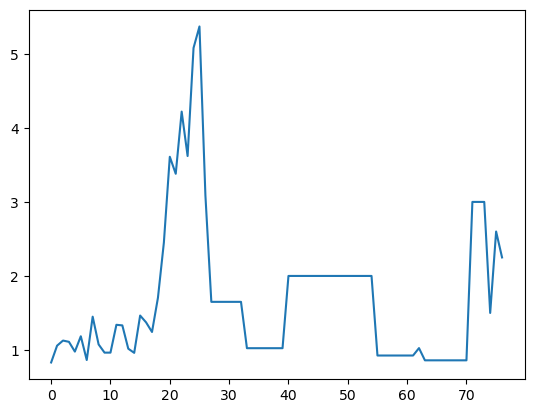

In [102]:
plt.plot([i for j in audio_lens for i in j]) # trial lengths (seconds) of all datasets

Check the calculated spectrogram. 

Compare the below two plots: Using matplotlib to plot the melspectrogram is not correct: y-axis is reversed.

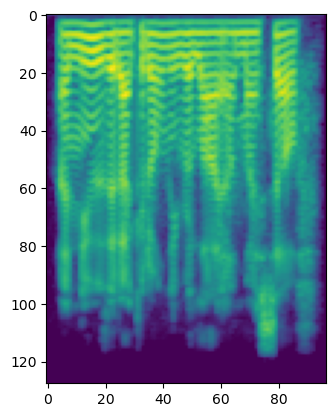

In [67]:
fig,ax=plt.subplots()
ax.imshow(target_specs[9][1])

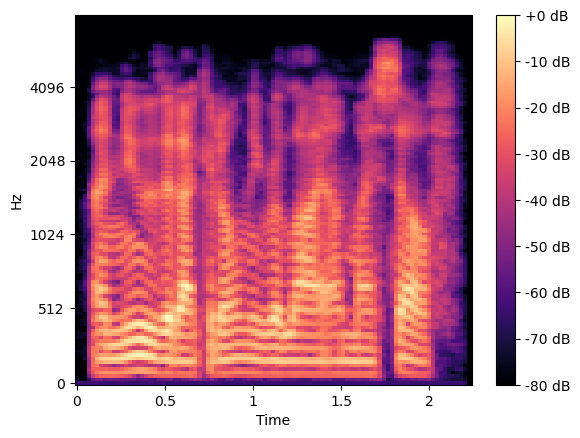

In [70]:
fig,ax=plt.subplots()
img = librosa.display.specshow(target_specs[9][1], x_axis='time',y_axis='mel', sr=22050,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

## Calculate CC: first fold the spectrogram to small windows, then calculate CC between two windows.

#### Folding

In [68]:
from speech_Dutch.utils import fold_2d23d
interval=1 # s
wind=int(22050*interval/2048) # 5 # 2048 is the default n_fft of librosa.feature.melspectrogram, and 22050 is the sampling rate.
stride=wind
# windowing operation
target_specs_windowing=[] # target_specs_windowing[dataset][trial][window_num,mel_bins,time]
for i in range(len(target_specs)):
    specs=target_specs[i] # per dataset
    tmp=[]
    for j in range(len(specs)):
        spec=specs[j] # per wave file
        #wind=int(0.5*sfs[i][j]) # second
        #stride=int(0.5*sfs[i][j]) # second
        spec_windowing,_=fold_2d23d(spec,spec,wind,wind,stride,stride)
        tmp.append(spec_windowing)
    target_specs_windowing.append(tmp)

In [69]:
pred_specs_windowing=[] # pred_specs_windowing[dataset][trial][window_num,mel_bins,time]
for i in range(len(pred_specs)):
    specs=pred_specs[i] # per dataset
    tmp=[]
    for j in range(len(specs)):
        spec=specs[j] # per wave file
        #wind=int(0.5*sfs[i][j]) # second
        #stride=int(0.5*sfs[i][j]) # second
        spec_windowing,_=fold_2d23d(spec,spec,wind,wind,stride,stride)
        tmp.append(spec_windowing)
    pred_specs_windowing.append(tmp)

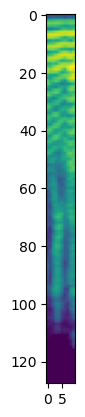

In [95]:
# check the windowing operation
fig,ax=plt.subplots()
ax.imshow(target_specs_windowing[9][1][4])

#### Calculate CC.

In [70]:
import math
from scipy.stats import pearsonr

# calculate CC across all datasets;  target_specs_windowing[dataset][trial][window,mel_bins,time] (12, 128, 10)
cc_datasets=[]
for i in range(len(target_specs_windowing)):
    targets=target_specs_windowing[i] # per dataset
    preds=pred_specs_windowing[i]
    cc_trials=[]
    for j in range(len(targets)):
        target=targets[j]
        pred=preds[j]
        ccs=[]
        avg_winds=[]
        for wind_t,wind_p in zip(target,pred): # (frequency, time)
            r,p=pearsonr(wind_t,wind_p,axis=1) # shape:(128,) there will be some nan if the input to the personr is constant;
            r=[i for i in r if not math.isnan(i)]
            if len(r)>0: # all 128 rows of wind_t are zeros
                avg=sum(r)/len(r) # per wind
                avg_winds.append(avg)
        avg_trial=sum(avg_winds)/len(avg_winds) # per trial
        cc_trials.append(avg_trial)
    cc_datasets.append(cc_trials)

C:\Users\xiaowu\AppData\Local\Temp\ipykernel_32956\865698624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p=pearsonr(wind_t,wind_p,axis=1) # shape:(128,) there will be some nan if the input to the personr is constant;


#### Plot CC.

In [125]:
cc_all=[i for j in cc_datasets for i in j] # flatten all scores
x=range(len(cc_all))
colors=[[i]*len(j) for i,j in enumerate(cc_datasets)]
colors=[i for j in colors for i in j]
colors=[i+1 for i in colors]
#plt.plot(x,cc_all,c=[i for j in colors for i in j])

# set x-label
x_label_tmp=[[i+1,]*len(files) for i, files in enumerate(pred_files)]
x_label=[j for i in x_label_tmp for j in i]

[Text(0, 0, '1'),
 Text(1, 0, '1'),
 Text(2, 0, '1'),
 Text(3, 0, '1'),
 Text(4, 0, '1'),
 Text(5, 0, '1'),
 Text(6, 0, '1'),
 Text(7, 0, '1'),
 Text(8, 0, '1'),
 Text(9, 0, '1'),
 Text(10, 0, '1'),
 Text(11, 0, '1'),
 Text(12, 0, '1'),
 Text(13, 0, '1'),
 Text(14, 0, '1'),
 Text(15, 0, '1'),
 Text(16, 0, '1'),
 Text(17, 0, '1'),
 Text(18, 0, '1'),
 Text(19, 0, '2'),
 Text(20, 0, '2'),
 Text(21, 0, '2'),
 Text(22, 0, '2'),
 Text(23, 0, '2'),
 Text(24, 0, '2'),
 Text(25, 0, '2'),
 Text(26, 0, '2'),
 Text(27, 0, '3'),
 Text(28, 0, '3'),
 Text(29, 0, '3'),
 Text(30, 0, '3'),
 Text(31, 0, '3'),
 Text(32, 0, '3'),
 Text(33, 0, '4'),
 Text(34, 0, '4'),
 Text(35, 0, '4'),
 Text(36, 0, '4'),
 Text(37, 0, '4'),
 Text(38, 0, '4'),
 Text(39, 0, '4'),
 Text(40, 0, '5'),
 Text(41, 0, '5'),
 Text(42, 0, '5'),
 Text(43, 0, '5'),
 Text(44, 0, '5'),
 Text(45, 0, '5'),
 Text(46, 0, '5'),
 Text(47, 0, '6'),
 Text(48, 0, '6'),
 Text(49, 0, '6'),
 Text(50, 0, '6'),
 Text(51, 0, '6'),
 Text(52, 0, '6'),
 Te

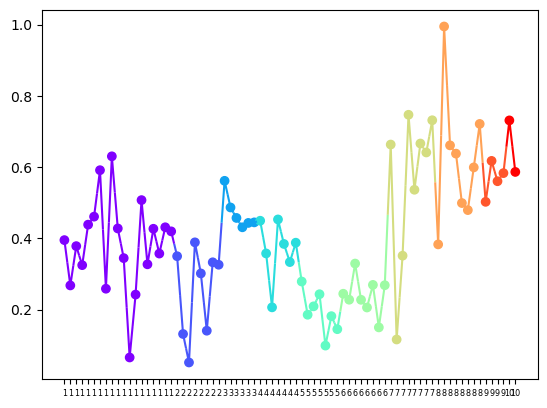

In [128]:
fig, ax = plt.subplots() # different color represents different dataset.
ax.scatter(x, cc_all, c=colors, cmap='rainbow')
colored_line(x, cc_all, c=colors, ax=ax, cmap='rainbow')
ax.set_xticks(x)
ax.set_xticklabels(x_label,fontsize='xx-small')

## Calculate STOI

In [130]:
from pystoi import stoi
stoi_all=[]
for i in range(len(target_files)):
    wave_files_target=target_files[i] # per dataset
    wave_files_pred=pred_files[i] # per dataset
    stoi_trials=[]
    for j in range(len(wave_files_target)):
        wave_file_t_trial=wave_files_target[j] # per wave file
        audio_t,sf=librosa.load(wave_file_t_trial)
        
        wave_file_p_trial=wave_files_pred[j]
        audio_p,sf=librosa.load(wave_file_p_trial)
        
        shortest=min(len(audio_t),len(audio_p))
        audio_t=audio_t[:shortest]
        audio_p=audio_p[:shortest]
        
        d = stoi(audio_t, audio_p, sf, extended=False)
        stoi_trials.append(d)
    stoi_all.append(stoi_trials)
stoi_all=[i for j in stoi_all for i in j]

D:\mydrive\python\dSPEECH\evaluation_matrix\pystoi\stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '


[Text(0, 0, '1'),
 Text(1, 0, '1'),
 Text(2, 0, '1'),
 Text(3, 0, '1'),
 Text(4, 0, '1'),
 Text(5, 0, '1'),
 Text(6, 0, '1'),
 Text(7, 0, '1'),
 Text(8, 0, '1'),
 Text(9, 0, '1'),
 Text(10, 0, '1'),
 Text(11, 0, '1'),
 Text(12, 0, '1'),
 Text(13, 0, '1'),
 Text(14, 0, '1'),
 Text(15, 0, '1'),
 Text(16, 0, '1'),
 Text(17, 0, '1'),
 Text(18, 0, '1'),
 Text(19, 0, '2'),
 Text(20, 0, '2'),
 Text(21, 0, '2'),
 Text(22, 0, '2'),
 Text(23, 0, '2'),
 Text(24, 0, '2'),
 Text(25, 0, '2'),
 Text(26, 0, '2'),
 Text(27, 0, '3'),
 Text(28, 0, '3'),
 Text(29, 0, '3'),
 Text(30, 0, '3'),
 Text(31, 0, '3'),
 Text(32, 0, '3'),
 Text(33, 0, '4'),
 Text(34, 0, '4'),
 Text(35, 0, '4'),
 Text(36, 0, '4'),
 Text(37, 0, '4'),
 Text(38, 0, '4'),
 Text(39, 0, '4'),
 Text(40, 0, '5'),
 Text(41, 0, '5'),
 Text(42, 0, '5'),
 Text(43, 0, '5'),
 Text(44, 0, '5'),
 Text(45, 0, '5'),
 Text(46, 0, '5'),
 Text(47, 0, '6'),
 Text(48, 0, '6'),
 Text(49, 0, '6'),
 Text(50, 0, '6'),
 Text(51, 0, '6'),
 Text(52, 0, '6'),
 Te

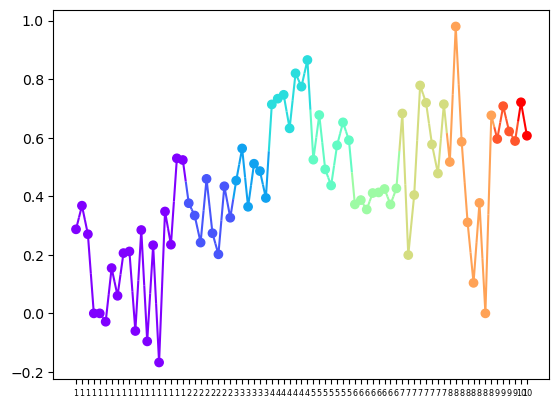

In [131]:
fig, ax = plt.subplots() # different color represents different dataset.
x=range(len(stoi_all))
ax.scatter(x, stoi_all, c=colors, cmap='rainbow')
colored_line(x, stoi_all, c=colors, ax=ax, cmap='rainbow')
ax.set_xticks(x)
ax.set_xticklabels(x_label,fontsize='xx-small')
# higher STOI for dataset 1 might be because of bad quality of both pred and terget file.

## Calculate MCD.

In [105]:
from mel_cepstral_distance import compare_audio_files
mcd_all=[]
for i in range(len(target_files)):
    wave_files_target=target_files[i] # per dataset
    wave_files_pred=pred_files[i] # per dataset
    mcd_trials=[]
    for j in range(len(wave_files_target)):
        trial_target=wave_files_target[j] # per wave file        
        trial_pred=wave_files_pred[j]
        
        mcd, penalty = compare_audio_files(trial_target,trial_pred) # n_fft=512,win_len=512 (it's in ms, not samples)
        mcd_trials.append(mcd)
    mcd_all.append(mcd_trials)

n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster computation
n_fft (32ms / 705 samples) should be a power of 2 in samples for faster comp

[Text(0, 0, '1'),
 Text(1, 0, '1'),
 Text(2, 0, '1'),
 Text(3, 0, '1'),
 Text(4, 0, '1'),
 Text(5, 0, '1'),
 Text(6, 0, '1'),
 Text(7, 0, '1'),
 Text(8, 0, '1'),
 Text(9, 0, '1'),
 Text(10, 0, '1'),
 Text(11, 0, '1'),
 Text(12, 0, '1'),
 Text(13, 0, '1'),
 Text(14, 0, '1'),
 Text(15, 0, '1'),
 Text(16, 0, '1'),
 Text(17, 0, '1'),
 Text(18, 0, '1'),
 Text(19, 0, '2'),
 Text(20, 0, '2'),
 Text(21, 0, '2'),
 Text(22, 0, '2'),
 Text(23, 0, '2'),
 Text(24, 0, '2'),
 Text(25, 0, '2'),
 Text(26, 0, '2'),
 Text(27, 0, '3'),
 Text(28, 0, '3'),
 Text(29, 0, '3'),
 Text(30, 0, '3'),
 Text(31, 0, '3'),
 Text(32, 0, '3'),
 Text(33, 0, '4'),
 Text(34, 0, '4'),
 Text(35, 0, '4'),
 Text(36, 0, '4'),
 Text(37, 0, '4'),
 Text(38, 0, '4'),
 Text(39, 0, '4'),
 Text(40, 0, '5'),
 Text(41, 0, '5'),
 Text(42, 0, '5'),
 Text(43, 0, '5'),
 Text(44, 0, '5'),
 Text(45, 0, '5'),
 Text(46, 0, '5'),
 Text(47, 0, '6'),
 Text(48, 0, '6'),
 Text(49, 0, '6'),
 Text(50, 0, '6'),
 Text(51, 0, '6'),
 Text(52, 0, '6'),
 Te

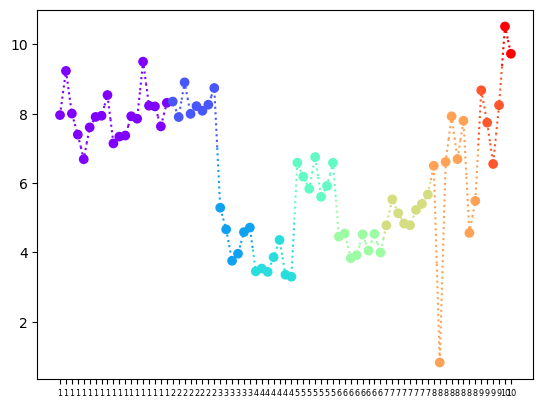

In [132]:
%matplotlib inline
fig, ax = plt.subplots() # different color represents different dataset.
mcd_all2=[i for j in mcd_all for i in j]
x=range(len(mcd_all2))
ax.scatter(x, mcd_all2, c=colors, cmap='rainbow')
colored_line(x, mcd_all2, c=colors, ax=ax, cmap='rainbow',linestyle='dotted') 
ax.set_xticks(x)
ax.set_xticklabels(x_label,fontsize='xx-small')
## why MCD of the dataset 9 and 10 is so high?

## Read manurally rated MOS.

In [48]:
folder='D:/data/BaiduSyncdisk/speech_Southmead/evaluation_matrix/audio_scores_GUI/*.txt'
score_files=[os.path.normpath(i) for i in glob.glob(folder)]

lines_all=[]
for file in score_files:
    with open(file,'r') as infile:
        lines_tmp=infile.read().split('\n')
    lines=[line for line in lines_tmp if len(line)>0]
    lines_all.append(lines)
#string.split('_')

In [96]:
scores_all=[]
for rates in lines_all: # per file
    scores=[]
    for i in range(len(rates)): # per audio file
        for j in range(len(rates)): # find audio file index
            if rates[j].split('_')[0]==str(i):
                scores.append(int(rates[j].split(' ')[-1]))
    scores_all.append(scores)


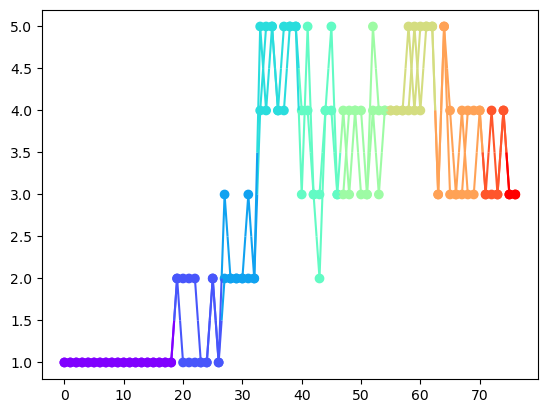

In [108]:
%matplotlib inline
fig, ax = plt.subplots() # different color represents different dataset.
for scores in scores_all:
    x=range(len(scores))
    ax.scatter(x, scores, c=colors, cmap='rainbow')
    colored_line(x, scores, c=colors, ax=ax, cmap='rainbow') 

In [112]:
%matplotlib qt
# plot everything together

fig, ax = plt.subplots()
x=range(len(scores))

# cc
ax.scatter(x, cc_all, c=colors, cmap='rainbow')
colored_line(x, cc_all, c=colors, ax=ax, cmap='rainbow',linestyle='dotted')

# stoi
ax.scatter(x, stoi_all, c=colors, cmap='rainbow')
colored_line(x, stoi_all, c=colors, ax=ax, cmap='rainbow',linestyle='solid')

# MCD
ax.scatter(x, mcd_all2, c=colors, cmap='rainbow')
colored_line(x, mcd_all2, c=colors, ax=ax, cmap='rainbow',linestyle='dashed') 

# MOS
ax.scatter(x, scores, c=colors, cmap='rainbow')
colored_line(x, scores, c=colors, ax=ax, cmap='rainbow',linestyle='dashdot') 

# length
ax.plot([i for j in audio_lens for i in j])